# Worked examples for image manipulation in python

We use the modules rasterio, skimage and sklearn here which may not be standard - if you don't have those installed then you will need to do so - either:
```
!conda install rasterio
or 
!pip install rasterio
```
And so on. 

(Note all images here are credited to - Copernicus Sentinel data 2024, CC BY 3.0 IG.)


This notebook contains working for the examples shown in the notes of the course, both for the simpler image operations, and the longer worked examples specifically working with geospatial images. The explanations throughout this code are relatively minimal and intended as a useful guide and example code for those already reasonably familiar with coding in python. If you are newer to python these examples may hopefully still be instructive, but may require more work to understand.


## Brightness adjustment

We can load in our first example image and adjust the brightness.


In [3]:
# First import required modules:
import skimage
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np

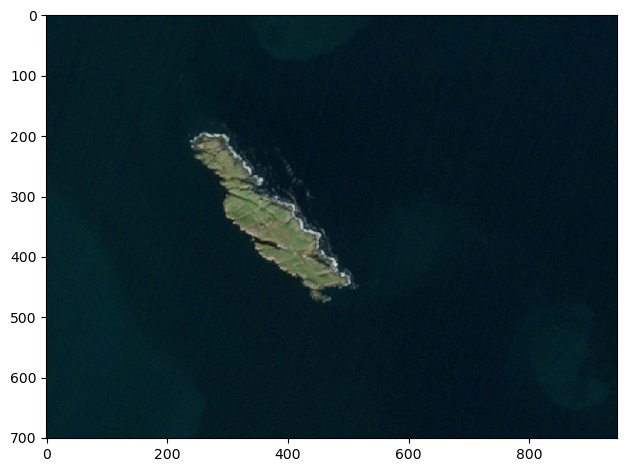

In [2]:
# Read in our first image - a Sentinel 2 satellite image but saved as a normal jpg
img1 = io.imread('2024-09-25-00_00_2024-09-25-23_59_Sentinel-2_L2A_True_color.jpg')
# Then show it
io.imshow(img1)
plt.show()

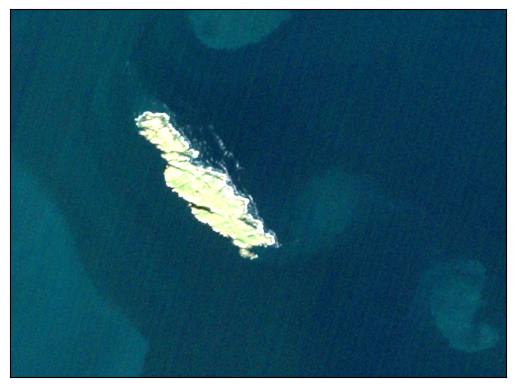

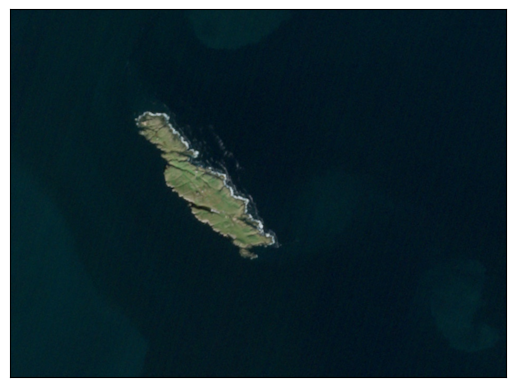

In [ ]:
# Separate the RGB channels
R, G, B = img1[:,:,0], img1[:,:,1], img1[:,:,2]

# Apply the brightness adjustment formulas
R = np.clip(2.5 * R,0,255)
G = np.clip(2.5 * G,0,255)
B = np.clip(2.5 * B,0,255)

# Convert back to integer data type
R = R.astype(np.uint8)
G = G.astype(np.uint8)
B = B.astype(np.uint8)

# Combine the channels back
adjusted_img = np.stack([R, G, B], axis=2)

# Show both images:
fig1 = plt.figure(1)
ax = fig1.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(adjusted_img)

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.imshow(img1)

plt.show()

## Contrast adjustment

We can adjust our image again using the contrast adjustment formula from the notes:

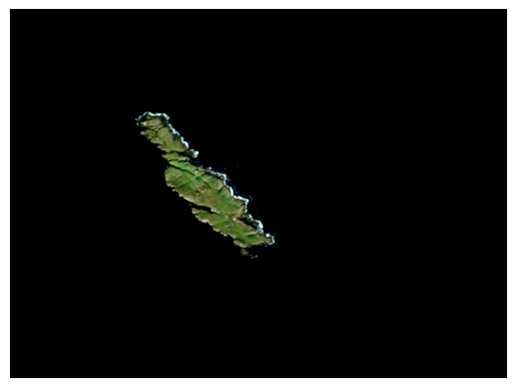

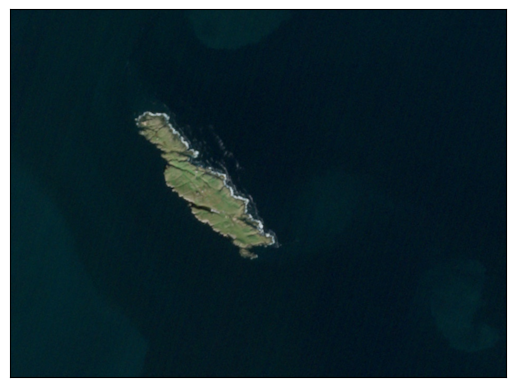

In [ ]:
# Set parameter a value:
a = 1.8

# Separate the RGB channels
R, G, B = img1[:,:,0], img1[:,:,1], img1[:,:,2]

# Apply the brightness adjustment formulas
R = np.clip(a*(R-128.0)+128.0,0,255)
G = np.clip(a*(G-128.0)+128.0,0,255)
B = np.clip(a*(B-128.0)+128.0,0,255)

# Convert back to integer data type
R = R.astype(np.uint8)
G = G.astype(np.uint8)
B = B.astype(np.uint8)

# Combine the channels back
adjusted_img = np.stack([R, G, B], axis=2)

# Show both images:
fig1 = plt.figure(1)
ax = fig1.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(adjusted_img)

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.imshow(img1)

plt.show()

## Image histograms

We can produce a plot with the histogram of our image. Firstly looking at the full colour image and producing a histogram for each of the RGB channels.

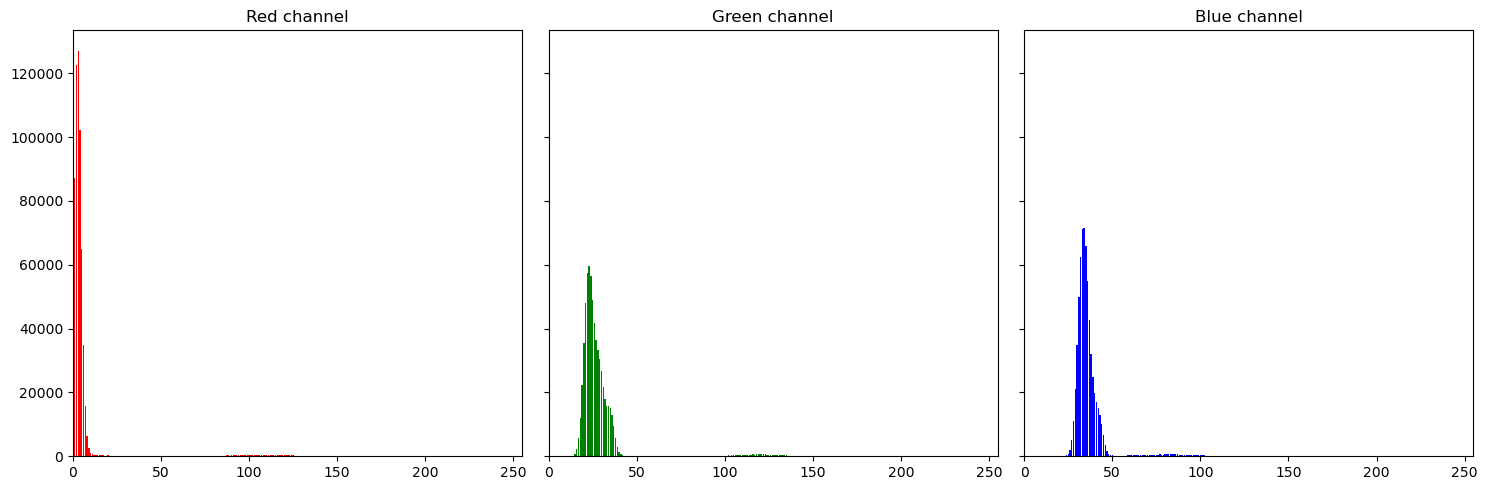

In [ ]:
from skimage import exposure

# Separate the RGB channels
R, G, B = img1[:,:,0], img1[:,:,1], img1[:,:,2]

# Create a figure for displaying histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
colors = ['red', 'green', 'blue']
channels = [R, G, B]

# Plot histograms for each channel
for ax, channel, color in zip(axes, channels, colors):
    hist, bins = exposure.histogram(channel)
    ax.bar(bins, hist, color=color)
    ax.set_xlim(0, 255)
    ax.set_title(f'{color.capitalize()} channel')

plt.tight_layout()
plt.show()

We can also convert our image to greyscale using one of the functions within Scikit-image and then produce the histogram for the single greyscale channel: 

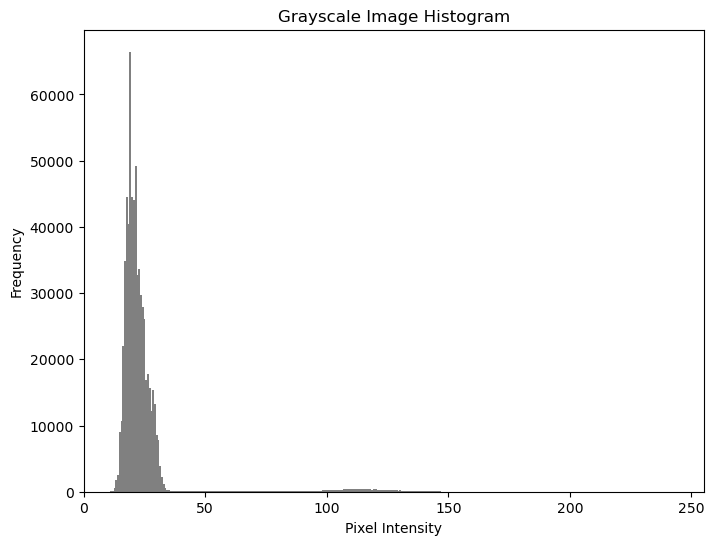

In [ ]:
from skimage import color, exposure

# Convert the image to grayscale
grayscale_image = color.rgb2gray(img1)*255

gray = grayscale_image.astype(np.uint8)

# Calculate histogram
hist, bins = exposure.histogram(grayscale_image,nbins=300)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(bins, hist, color='gray')
plt.title('Grayscale Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.xlim(0, 255)
plt.show()

## Convert an image to greyscale and show it

Here we just convert the image to greyscale and plot it

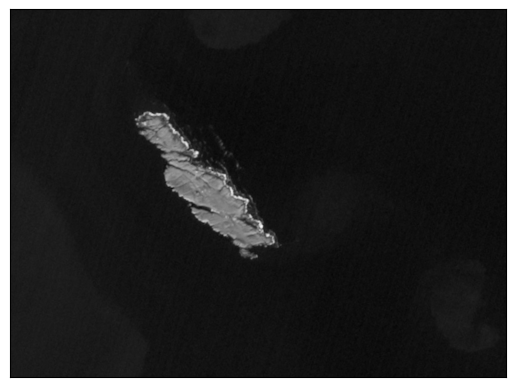

In [7]:
# Convert the image to grayscale
grayscale_image = color.rgb2gray(img1)*255

gray = grayscale_image.astype(np.uint8)

# Show the image removing axis labels
fig1 = plt.figure(1)
ax = fig1.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(gray,cmap='gray')
plt.show()

## Using an edge filter

Here we take the greyscale image we just produced and apply an edge filter 

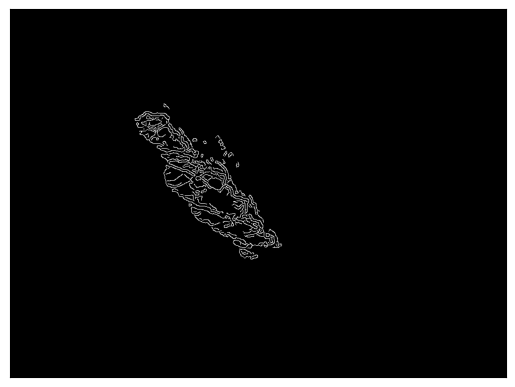

In [8]:
from skimage import feature

# Use a canny edge filter to get the edges
edges1 = feature.canny(gray)

# Plot the edge map
fig1 = plt.figure(1)
ax = fig1.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(edges1, cmap='gray')
plt.show()

## Blurring an image

Last in this section we show the use of a Gaussian blur on the colour version of the same image:

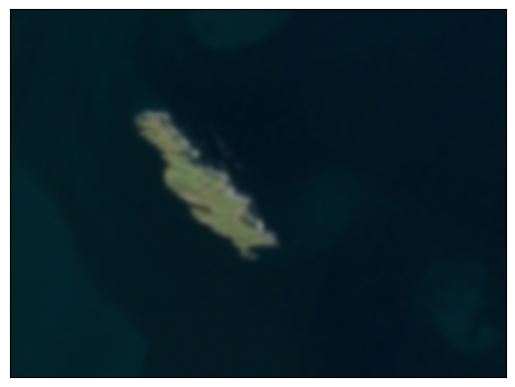

In [9]:
from skimage import filters

# Apply the Gaussian filter to blur the image:
filt = filters.gaussian(img1, sigma=5,channel_axis=-1)

# Show the blurred image:
fig1 = plt.figure(1)
ax = fig1.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(filt)
plt.show()

----

# Here is the code to work through the examples discussed in the examples section of the course. 

## Example 1:  Using a threshold - finding a cloud mask.

For this example we will convert an image containing clouds to greyscale, and then try using a threshold to determine which pixels are cloud within the image.

In [10]:
#First load in the modules scikit-image, matplotlib:
import skimage
import matplotlib.pyplot as plt
import rasterio
import numpy as np

In [11]:
# Open the Geotiff of the image using the rasterio module:
src = rasterio.open('2024-10-01-00_00_2024-10-01-23_59_Sentinel-2_L2A_True_color.tiff')

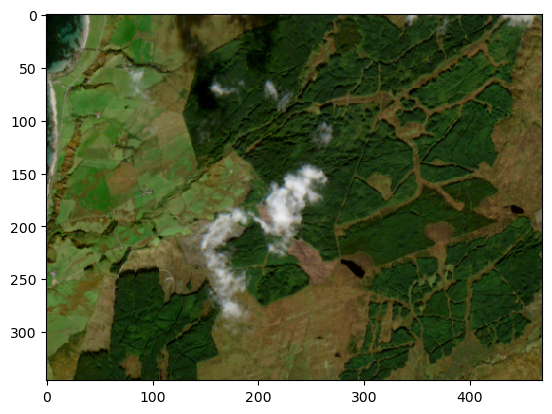

In [12]:
# Read in the separate RGB elements of the Geotiff into arrays
R = src.read(1)
G = src.read(2)
B = src.read(3)

# Stack the colour channel arrays into a single image
img = np.stack((R,G,B),axis=-1)

# Show the image
plt.imshow(img)
plt.show()

In [13]:
from skimage import io, color, exposure

# Convert the image to grayscale
grayscale_image = color.rgb2gray(img)*255

gray = grayscale_image.astype(np.uint8)

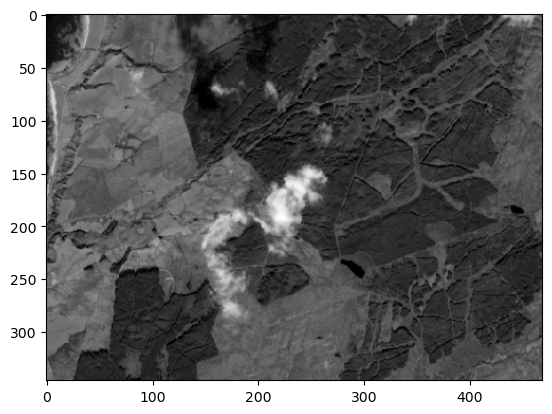

In [14]:
# Show the greyscale image:
plt.imshow(gray,cmap='gray')
plt.show()

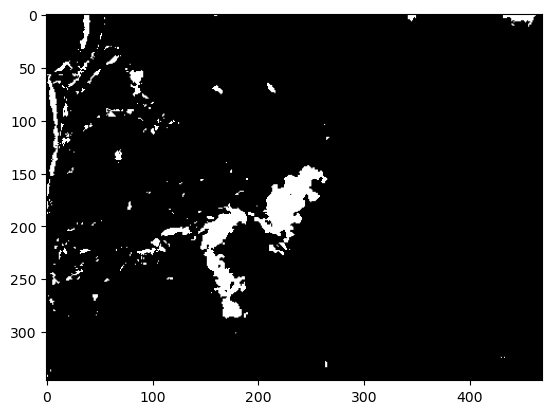

In [15]:
# Threshold the greyscale image:
cloud = gray > 120

# Show the thresholded image:
plt.imshow(cloud,cmap='gray')
plt.show()

We can maybe do slightly better by considering thresholds in the RGB channels directly rather than just on the combination of them in a greyscale single channel. Recall that white clouds will have to be high in all three channels, which distinguiushes them from lighter pixels of a distinctly different colour which may be low in one of the three colour channels.

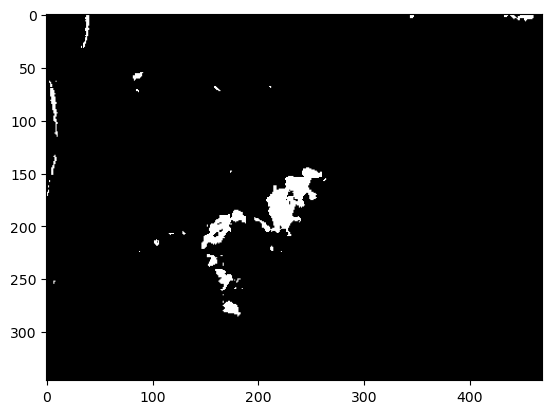

In [ ]:
# The image is mostly green so we should be stricter with the green threshold than the others:
cloudR = R > 100
cloudG = G > 150
cloudB = B > 100

#Combine the three thresholded masks for each channel into one mask:
cloud = np.logical_and(cloudR,cloudG,cloudB)

# Show the image:
plt.imshow(cloud,cmap='gray')
plt.show()

# Example 2: Segmenting using edges - finding an island coastline. 

For the next example we will use an edge map and appropriate filtering to try and find the coastline of an island

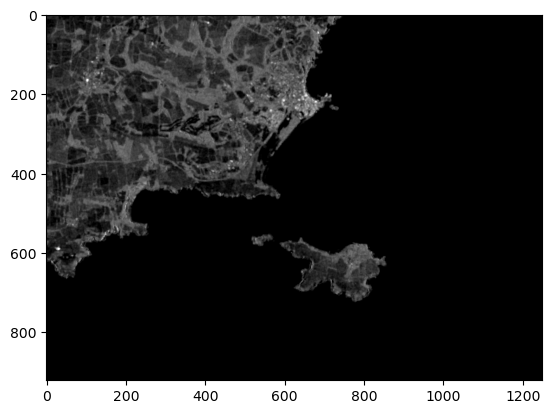

In [17]:
# Open our image using rasterio and show the first channel:
src1 = rasterio.open('2024-01-01-00_00_2024-01-01-23_59_Sentinel-1_IW_VH_-_decibel_gamma0.tiff')
plt.imshow(src1.read(1), cmap='gray')
plt.show()

from skimage import feature

# Find the edges of the first channel
edges1 = feature.canny(src1.read(1))

# Show the edge map
fig1 = plt.figure(1)
ax = fig1.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(edges1, cmap='gray')
plt.show()

Next threshold the land and then find the edge map:

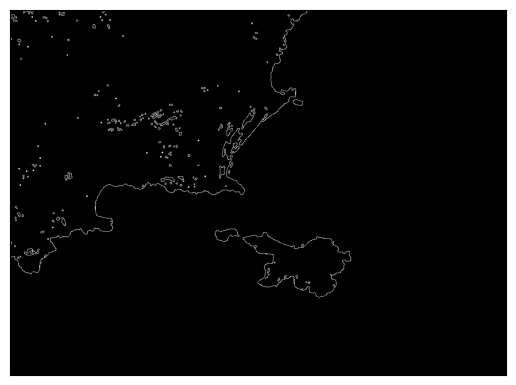

In [18]:
# Threshod the land as any value bigger than zero:
land = src1.read(1) > 1
# Take an edge map
edges2 = feature.canny(land)

# Show the edge map
fig1 = plt.figure(1)
ax = fig1.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(edges2, cmap='gray')
plt.show()

Here we use some more binary (black & white only) image operations using helper function in Scikit image to help reduce the number of edges. We use area opening to get rid of some small edge lines, dilation to join up smaller edges, and finally remove any edges with small numbers of pixels in them. 

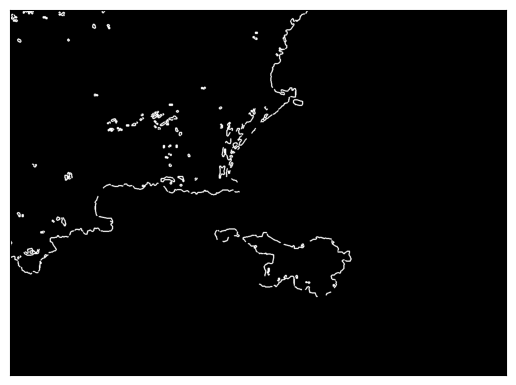

In [19]:
from skimage import morphology
# Remove small edges, dilate to join up chunks of edges into linger features, then remove small edge areas again:
edit = morphology.area_opening(edges2,3)
edit = morphology.binary_dilation(edit)
edit = morphology.remove_small_objects(edit,40)

# Show the resulting edge map:
fig1 = plt.figure(1)
ax = fig1.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(edit, cmap='gray')
plt.show()

Lastly show a pipeline of using a threshold, then blur, then edge map on our image:

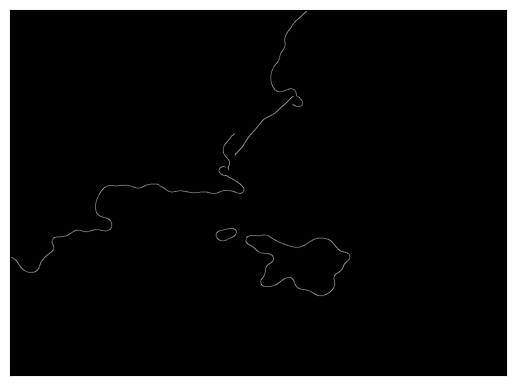

In [20]:
from skimage import filters

# Threshold, then blur, then take an edge filter:
land = src1.read(1) > 5
land = filters.gaussian(land,10)
edges2 = feature.canny(land)

# Show the resulting edges:
fig1 = plt.figure(1)
ax = fig1.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(edges2, cmap='gray')
plt.show()

# Example 3: Segmenting using clustering – finding regions in an image 

In this section we demonstrate using clustering on our image to cluster like colours within the image together.

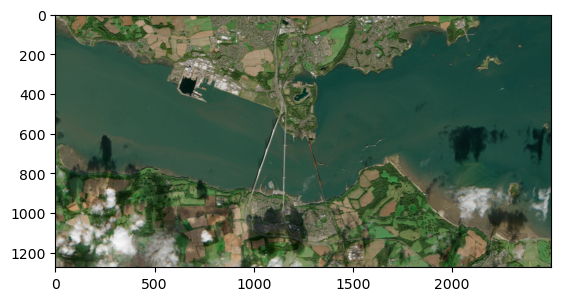

In [21]:
#Read our Geotiff, split the RGB channels, and combine them into one single image array:
src3 = rasterio.open('2024-09-25-00_00_2024-09-25-23_59_Sentinel-2_L2A_True_color-2.tiff')
R = src3.read(1)
G = src3.read(2)
B = src3.read(3)

img = np.stack((R,G,B),axis=-1)

# Show the image:
plt.imshow(img)
plt.show()

First we show the use of the Scikit image segmentation tool called SLIC. This clusters colour and space together [Formally the feature space is (x,y,r,g,b)]. 
Here we show usage with a guide to aim for around 100 clusters with moderate spatial compactness:

1 45


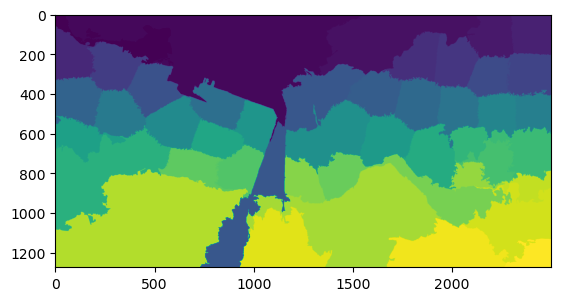

In [22]:
from skimage import segmentation

# Segment the image into clusters using SLIC tool:
seg = segmentation.slic(img,n_segments=100, compactness=5, sigma=1)

# Print the max and min labels so we know the number of clusters:
print(seg.min(), seg.max())

# Show the clusters using a false colour scheme one colour per cluster
plt.imshow(seg)
plt.show()

Next we cluster simply just using colour. This requires use of the K-means function contained in Scikit learn. Note we need to reshape the image array to make sense when we pass it to the clustering algorithm, and then reshape the result when we get it back to interpret it as an image.

(1274, 2500, 3)


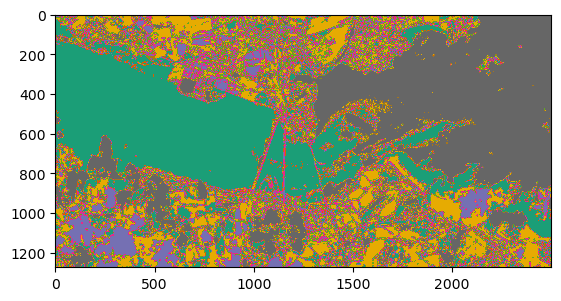

In [23]:
import numpy as np
from sklearn.cluster import k_means

# Check the image shape so we can reshape appropriately
print(img.shape)
nx = img.shape[1]
ny = img.shape[0]

# Use the Kmeans function to cluster this image - here into 4 clusters:
centroid, label, inertia = k_means(img.reshape(nx*ny, 3), n_clusters=4, n_init="auto", random_state=0)

# Show the clusters with a chosen colourmap one colour per cluster:
plt.imshow(label.reshape(ny, nx, 1),cmap='Dark2')
plt.show()

Lastly we can pick our the cluster labelled 0 from the above and look at it separately. We can find the average colour of all the points within the cluster. To do that we need to exclude any points with a zero in them when we consider our masked array:

60.69051539809888 87.13317467833583 62.88719533850461


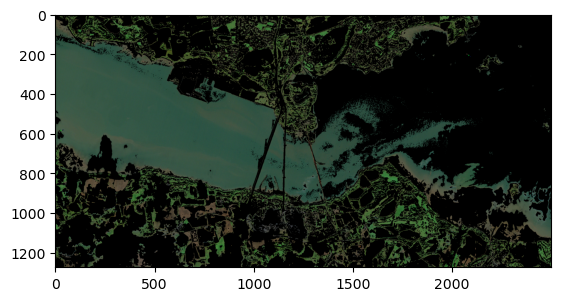

In [ ]:
# Make a true/False mask for all the points labelled as in cluster 0:
clustermask = label==0

# Multiply the mask into the array which sets most points to zero, and retains a value only in those points
# within the cluster labelled 0:
mask_img = img*clustermask.reshape(1274, 2500, 1)

# Separate the RGB channels of the masked array:
R = mask_img[:,:,0]
G = mask_img[:,:,1]
B = mask_img[:,:,2]

# Define a quick function to find the mean value within these masked arrays
# ignoring the zero values:
def ave_nozeros(array):
    ave = 0
    count = 0
    for i,ele in enumerate(array.flatten()):
        if ele>0:
            ave = ave + ele
            count+=1
    if count >0:
        return ave/count
    else:
        return 0

# Print out the mean RGB values for the cluster:
print(ave_nozeros(R),ave_nozeros(G),ave_nozeros(B))

# Show the cluster in original image RGB value:
plt.imshow(mask_img)
plt.show()